This tutorial will walk you through the basic concept to understand representational similarity analysis (RSA) and how to apply it using the PcmPy toolbox. To find out how to use the rsatoolbox instead you can check this tutorial.

In [36]:
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import PcmPy as pcm
import pandas as pd
import nitools as nt
import pickle

plt.style.use('default')


In [37]:
f = open('data_demo_smp.p', 'rb')
Y, ResMS, cond_vec, part_vec, cond_names = pickle.load(f)
N = Y.shape[1]

A central concept to keep in mind to understand RSA is the **second moment matrix** $\mathbf{G}$:

$$ G = \frac{{YY^T}}{P} $$

Where $Y$ is a matrix with experimental observations (e.g., trials, conditions) in the rows and channels (e.g., electrodes, voxels) in the columns and $P$ is the number of channels. In our example case, each row in Y contains the beta coefficients estimated in S1 for each condition. Note that the second moment matrix is different from the variance-covariance matrix:

$$ \mathsf{\Sigma} = \frac{(Y - \bar{Y})^T (Y - \bar{Y})}{N - 1} $$

Here, we subtract the column-wise mean $\bar{Y}$ from $Y$. Instead, the second moment matrix maintains information about the mean activation observed in each condition.

Let's now compute the second moment matrix for the first run in our example data:

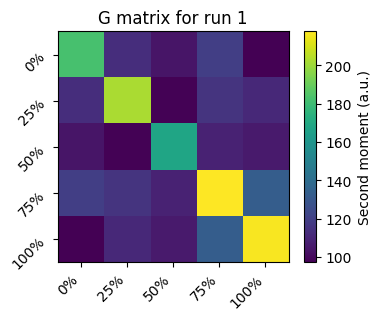

In [38]:
G = Y[:5] @ Y[:5].T / N

plt.figure(figsize=(4,3))
plt.imshow(G)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45, ha='right')
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45, ha='right')
plt.title('G matrix for run 1')
plt.colorbar(label='Second moment (a.u.)')
plt.show()

From the second moment matrix it is possible to calculate the squared euclidean distances between conditions. The squared euclidean distance between two vectors $ \mathsf{y}_{i} $ and $ \mathsf{y}_{j} $ is:

$$ \mathsf{D}_{i,j}^2 = (y_{i} - y_{j})(y_{i} - y_{j})^T $$

Expanding the terms inside the parentheses:

$$ \mathsf{D}_{i,j}^2 = y_{i}y_{j}^T - 2y_{i}y_{j}^T + y_{i}y_{j}^T $$

If we look back at the definition of second moment matrix, for any $i$ and $j$:

$$ {G}_{i,j} = \frac{y_{i}y_{j}^T}{P} $$

Therefore, we can rewrite the squared Euclidean distance formula for the first block:

$$ {D}_{i,j}^2 = G_{i,i} - 2G_{i,j} + G_{j,j} $$

In PcmPy, we can compute the ${D}^2$ from $G$ using the `G_to_dist` function:

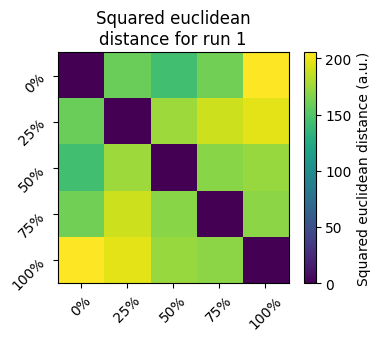

In [39]:
D_eucl = pcm.G_to_dist(G)

plt.figure(figsize=(4,3))
plt.imshow(D_eucl)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Squared euclidean\ndistance for run 1')
plt.colorbar(label='Squared euclidean distance (a.u.)')

The problem with this distance metric is that it will be always (and trivially) larger than zero, even when there is no true distance between conditions. This is because data are collected in the presence of noise. Noise inflates distances: two conditions will be always show some distance relative to each other because noise pulls them apart. More specifically, using the above definition of second moment matrix $G$, in the $nth$ block $\hat{G_n}$ is estimated as:

$$ \hat{G_n} = \frac{{Y_n Y_n^T}}{N} $$

But $Y_n$ is affected noise $ \epsilon_n $. Therefore, $\hat{G_n}$ becomes:

$$ \hat{G_n} = (Y_n + \epsilon_n)(Y_n + \epsilon_n)^T $$

Expanding:

$$ \hat{G_n} = Y_n Y_n^T + Y_n\epsilon_n^T + \epsilon_n Y_n^T + \epsilon_n \epsilon_n^T $$

$ Y_n\epsilon_n^T=0 $  because noise is assumed to be orthogonal to the data. Therefore:

$$ \hat{G_n} = Y_nY_n^T + \epsilon_n \epsilon_n^T $$

$\epsilon_n \epsilon_n^T$ corresponds to the covariance of the noise $\Sigma$. Thus, the expected value of $\hat{G_n}$ estimated in the $nth$ block is:

$$\mathbb{E}[\hat{G_n}] = G_n + \Sigma $$

As a consequence, the expected estimate of distance between two conditions $y_{n,i}$ and $y_{n,j}$ in the first block becomes:

$$\mathbb{E}[\hat{D}_{n,i,j}^2] = y_{n,i} y_{n,i}^T + \epsilon_{n,i} \epsilon_{n,i}^T - 2(y_{n,i} y_{n,j}^T + \epsilon_{n,i} \epsilon_{n,j}^T) + y_{n,j} y_{n,j}^T + \epsilon_{n,j} \epsilon_{n,j}^T $$

That is, the estimate of the distance $\hat{D_{n,i,j}^2}$ is inflated by $ \epsilon_{n,i} \epsilon_{n,i}^T -2\epsilon_{n,i} \epsilon_{n,j}^T +  \epsilon_{n,j} \epsilon_{n,j}^T$

How do we obtain an unbiased $\hat{G}$ that gets rid of $\Sigma$? In RSA, this is achieved by computing the cross-validated second moment matrix $G_{cv}$:

$$ Gc = \frac{1}{N} \sum_{i=1}^{N} Y_i \bar{Y_{\neg i}}^T $$

Where $N$ is the number of blocks $Y_i$ is the data from one block and $\bar{Y_{\neg i}}$ is the average of all blocks except $i$:

$$ \bar{Y}_{\neg i} = \frac{1}{N-1} \sum_{j \neq i} Y_j $$

The cross-validated second moment matrix between two blocks $i$ and $j$ is:

$$ \hat{Gc_{i,j}} = \frac{{Y_{i}Y_{j}^T}}{P} $$

$Y_i$ and $Y_j$ will be affected by noise $\epsilon_i$ and $\epsilon_j$:

$$ \hat{Gc_{i,j}} = (Y_{i} + \epsilon_{i})(Y_{i} + \epsilon_{j})^T $$

Expanding:

$$ \hat{Gc_{i,j}} = Y_{i}Y_{j}^T + Y_{i}\epsilon_{j}^T + \epsilon_{i}Y_{j}^T + \epsilon_{i} \epsilon_{j}^T $$

In this case, not only $Y_{i} \epsilon_{j}^T=0$ and $\epsilon_{i}Y_{j}^T=0$, but also $\epsilon_{i} \epsilon_{j}^T=0 $ because the noise is assumed to be orthogonal between different blocks. This means that, with cross-validation, we achieved an unbiased estimate of the second moment matrix.

The cross-validated G matrix can be computed in PcmPy using the `est_G_crossval` function. `cond_vec` is  a vector of condition labels and `part_vec` is a vector of partition labels (i.e., the block number):


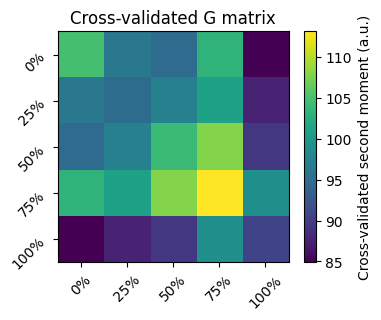

In [40]:
G_cv, _ = pcm.est_G_crossval(Y, cond_vec, part_vec)

plt.figure(figsize=(4, 3))
plt.imshow(G_cv)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Cross-validated G matrix')
plt.colorbar(label='Cross-validated second moment (a.u.)')

From `G_cv` we can now compute the cross-validated squared euclidean distance with `G_to_dist`. Importantly, cross-validated distance **CAN BE NEGATIVE**. This might seem counterintuitive, but we have to keep in mind that what we are computing is an **estimate** of the true distances. If $\mathbb{E}[\hat{D}_{n,i,j}^2] = 0 $, then $\hat{D}_{n,i,j}^2$ will fluctuate around 0 across observations, showing negative value half of the times.

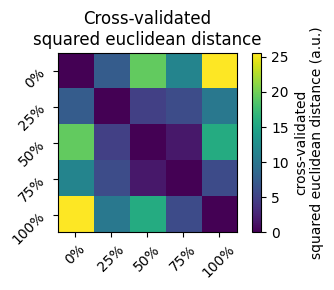

In [41]:
D_eucl_cv = pcm.G_to_dist(G_cv)

plt.figure(figsize=(4,3))
plt.imshow(D_eucl_cv)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Cross-validated\nsquared euclidean distance')
plt.colorbar(label='cross-validated\nsquared euclidean distance (a.u.)')
plt.tight_layout()

There is another problem that we need to address to accurately estimate distances. Different channels often have different noise variance, or correlated noise with each other. This introduces distortions in the distances between conditions. Let's inspect this problem in some simulated data:

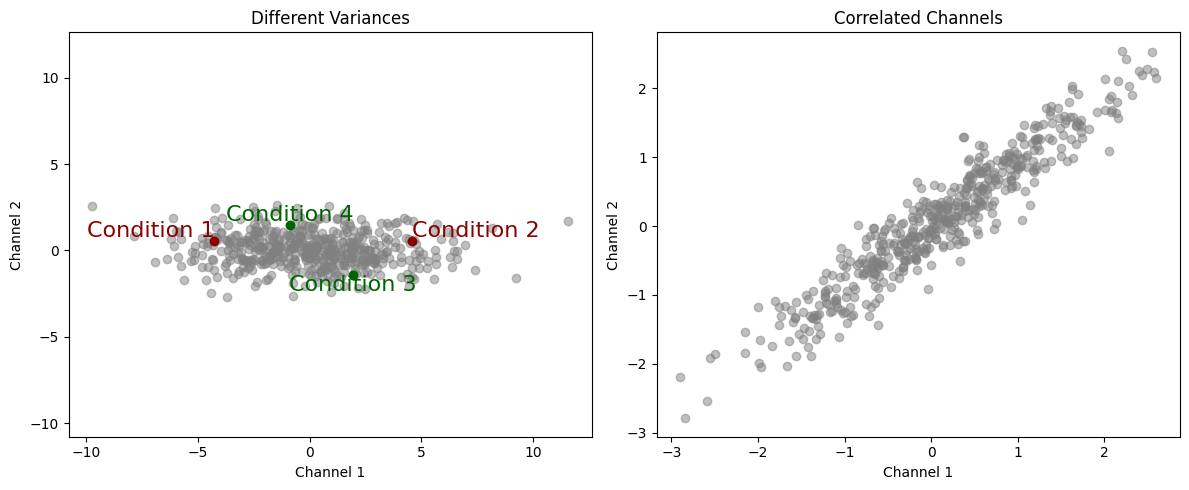

In [42]:
# Generate synthetic data with different variances and correlations
np.random.seed(42)
n_samples = 500

# Scenario 1: Different variances
x1 = np.random.randn(n_samples) * 3  # Large variance
y1 = np.random.randn(n_samples)  # Small variance

# Scenario 2: Correlated channels
x2 = np.random.randn(n_samples)
y2 = 0.9 * x2 + np.random.randn(n_samples) * 0.3  # Strong correlation

# Create a scatter plot to visualize these issues
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot: Different variances
ax[0].scatter(x1, y1, alpha=0.5, color='grey')
ax[0].set_ylim(ax[0].get_xlim())
ax[0].set_title("Different Variances")
ax[0].set_xlabel("Channel 1")
ax[0].set_ylabel("Channel 2")

ax[0].text(x1[23], y1[23], 'Condition 1', color='darkred', ha='right', va='bottom',fontsize=16)
ax[0].scatter(x1[23], y1[23], color='darkred')

ax[0].text(x1[3], y1[3], 'Condition 2', color='darkred', ha='left', va='bottom',fontsize=16)
ax[0].scatter(x1[3], y1[3], color='darkred')

ax[0].text(x1[2], y1[2], 'Condition 3', color='darkgreen', ha='center', va='top',fontsize=16)
ax[0].scatter(x1[2], y1[2], color='darkgreen')

ax[0].text(x1[43], y1[43], 'Condition 4', color='darkgreen', ha='center',va='bottom', fontsize=16)
ax[0].scatter(x1[43], y1[43], color='darkgreen')

# Plot: Correlated channels
ax[1].scatter(x2, y2, alpha=0.5, color='grey')
ax[1].set_title("Correlated Channels")
ax[1].set_xlabel("Channel 1")
ax[1].set_ylabel("Channel 2")

plt.tight_layout()
plt.show()

In the left panel, each gray point represent an activity pattern defined by Channel 1 and Channel 2 for one condition. The distance between Condition 1 and Condition 2 is larger compared to the distance between Condition 3 and Condition 4 because Channel 1 has a much larger variance compared to Channel 2. The same may happen if the two channels are highly correlated, like in the scenario depicted in the right panel. Something similar can happend in fMRI data. This is the covariance matrix of the first 100 voxels in S1:

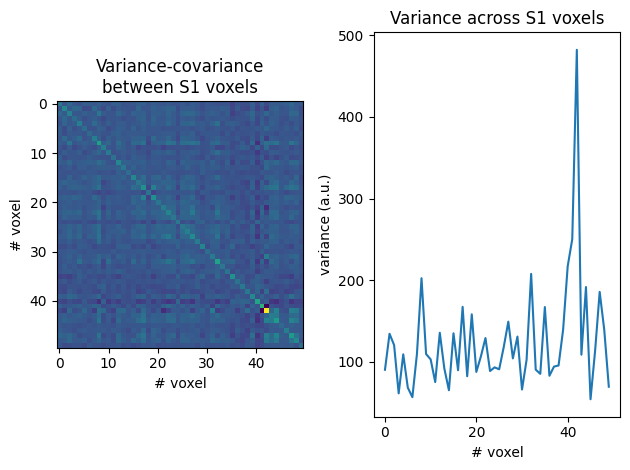

In [43]:
cov = np.cov(Y[:, :50].T)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(cov)
ax[0].set_xlabel('# voxel')
ax[0].set_ylabel('# voxel')
ax[0].set_title('Variance-covariance\nbetween S1 voxels')
# ax[0].set_colorbar(label='covariance')

ax[1].plot(np.diag(cov))
ax[1].set_ylabel('variance (a.u.)')
ax[1].set_xlabel('# voxel')
ax[1].set_title('Variance across S1 voxels')

fig.tight_layout()
plt.show()

Both the variance (on-diagonal, see also right panel) and the covariance (off-diagonal) vary substantially across voxels. In part, this is because the beta coefficients are estimated in the presence of noise which is different across voxels and distinctively correlated between voxels. In RSA, we correct for this by prewhitening our beta coefficients:

$$ Y_{prewhitened} = \Sigma^{\frac{1}{2}}Y $$

Where $\Sigma$ is the variance-covariance matrix of the residuals from the first-level GLM. There are two types of prewhitening we can perform on beta coefficients:

- **Univariate prewhitening**: we assume that covariance between voxels is 0 and only correct for differences in noise variance (i.e., the distortion depicted in the left panel of cell 7). To do this, we divide our betas by the square root of the residual mean squares stored in the ResMS.nii file after GLM estimation with SPM12.
- **Multivariate prewhitening**: we prewhiten the data using the full covariance matrix of the noise $\Sigma$. To compute it, we first need the timeseries of the residuals after GLM estimation, which is not provided by SPM12. However, we can retrieve it using the `spm` module from `nitools`.

For this example, we will first use univariate prewhitening:

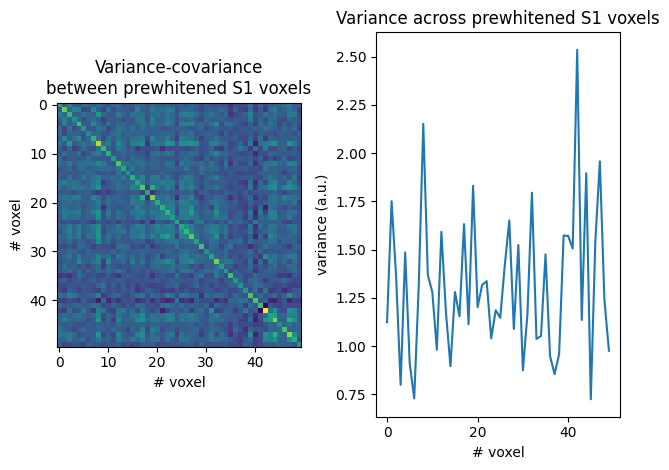

In [44]:
Y_prewhitened = Y / np.sqrt(ResMS)

cov_prewhitened = np.cov(Y_prewhitened[:, :50].T)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(cov_prewhitened)
ax[0].set_xlabel('# voxel')
ax[0].set_ylabel('# voxel')
ax[0].set_title('Variance-covariance\nbetween prewhitened S1 voxels')
# ax[0].set_colorbar(label='covariance')

ax[1].plot(np.diag(cov_prewhitened))
ax[1].set_ylabel('variance (a.u.)')
ax[1].set_xlabel('# voxel')
ax[1].set_title('Variance across prewhitened S1 voxels')

fig.tight_layout()
plt.show()

Univariate prewhitening made variances across voxels more homogeneous. The squared Euclidean distance between patterns $y_i$ and $y_j$ prewhitened using the covariance of the noise is:

$$ D_{i,j}^2 = (\Sigma^{\frac{1}{2}} y_i - \Sigma^{\frac{1}{2}} y_j) (\Sigma^{\frac{1}{2}} y_i - \Sigma^{\frac{1}{2}} y_j)^T $$

Expanding:

$$ D_{i,j}^2 = \Sigma^{-1} y_i y_i^T + \Sigma^{-1} y_j y_j^T - 2\Sigma^{-1} y_j y_j^T $$

We can now group for $ \Sigma^{-1} $:

$$ D_{i,j}^2 = ( y_i - y_j) \Sigma^{-1} (y_i - y_j)^T$$

This new distance metric corresponds to the Euclidean distance normalized by the covariance of the noise and is generally referred to as **Mahalanobis distance**. To obtain the **cross-validated mahalanobis distance** or **crossnobis distance** we just need to submit the prewhitened beta coefficients to `est_G_crossval` and then transform the G matrix into a squared distance matrix with `G_to_dist`:

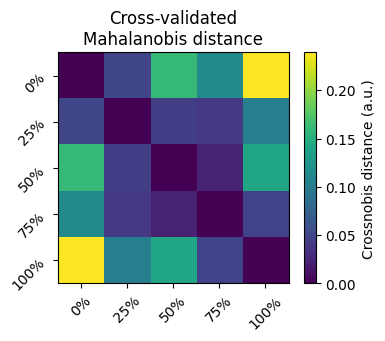

In [45]:
G_crossnobis, _ = pcm.est_G_crossval(Y_prewhitened, cond_vec, part_vec)
D_crossnobis = pcm.G_to_dist(G_crossnobis)

plt.figure(figsize=(4, 3))
plt.imshow(D_crossnobis)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Cross-validated\nMahalanobis distance')
plt.colorbar(label='Crossnobis distance (a.u.)')